# Synthetic RTT Data Analysis

### Dataset:

This dataset mimics a real Referral to Treatment (RTT) dataset, where patients are referred to the Trust for treatment. Patients are assigned the next available appointment with a healthcare professional, based on their clinical need and wait time, such that patients who have a greater clinical risk and those who have been waiting longest are seen first. There are five columns in the synthetic dataset: the patient's age, the index of multiple deprivation of their home address, the patient's ethnicity, the date the patient was seen by a healthcare professional and the date that they were referred to be seen. 

### Tasks: 
You have been asked by a senior member of the Performance team to ascertain whether there are any inequalities in the time patients have to wait to be seen by a clinician. Please think about how you would analyse the dataset to answer this question.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pingouin as pg
import scikit_posthocs as sp

/Users/techonn/opt/anaconda3/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Load the dataset

In [2]:
df = pd.read_excel('SyntheticData.xlsx', sheet_name = 'SyntheticRTTData')

In [3]:
# Display the first few rows to understand the dataset structure
df.head()

,Patient_Age,Index_of_Multiple_Deprivation,Ethnicity,Seen_Date,Wait_Start_Date
0,47.0,7.0,White British,2023-01-01,2022-12-28
1,55.0,9.0,White British,2023-01-02,2022-12-03
2,80.0,4.0,White - any other white background,2023-01-14,2022-10-22
3,42.0,6.0,White British,2023-01-29,2023-01-20
4,23.0,7.0,White British,2023-01-22,2022-12-22


## Exploratory Data Analysis

To analyse inequality in RTT wait time, we need to create a new column 'Wait Time'

In [4]:
df['Wait_Time'] = (df['Seen_Date'] - df['Wait_Start_Date']).dt.days
df.head()

,Patient_Age,Index_of_Multiple_Deprivation,Ethnicity,Seen_Date,Wait_Start_Date,Wait_Time
0,47.0,7.0,White British,2023-01-01,2022-12-28,4.0
1,55.0,9.0,White British,2023-01-02,2022-12-03,30.0
2,80.0,4.0,White - any other white background,2023-01-14,2022-10-22,84.0
3,42.0,6.0,White British,2023-01-29,2023-01-20,9.0
4,23.0,7.0,White British,2023-01-22,2022-12-22,31.0


Explore summary statistics

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8127 entries, 0 to 8126
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Patient_Age                    8123 non-null   float64       
 1   Index_of_Multiple_Deprivation  8126 non-null   float64       
 2   Ethnicity                      8122 non-null   object        
 3   Seen_Date                      8121 non-null   datetime64[ns]
 4   Wait_Start_Date                8126 non-null   datetime64[ns]
 5   Wait_Time                      8120 non-null   float64       
dtypes: datetime64[ns](2), float64(3), object(1)
memory usage: 381.1+ KB


In [6]:
table1 = df.describe(include='all')
table1.transpose().drop(['Wait_Start_Date','Seen_Date'])

/var/folders/hy/3s7ydp6x6q318tvnp5t1_mr40000gn/T/ipykernel_94025/2125770131.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  table1 = df.describe(include='all')
/var/folders/hy/3s7ydp6x6q318tvnp5t1_mr40000gn/T/ipykernel_94025/2125770131.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  table1 = df.describe(include='all')


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Patient_Age,8123.0,NaN,NaN,NaN,NaT,NaT,52.377201,22.892343,0.0,36.0,56.0,72.0,97.0
Index_of_Multiple_Deprivation,8126.0,NaN,NaN,NaN,NaT,NaT,4.761014,2.46706,1.0,3.0,4.0,7.0,10.0
Ethnicity,8122,17,White British,6064,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wait_Time,8120.0,NaN,NaN,NaN,NaT,NaT,114.859483,136.989189,0.0,12.0,52.0,181.0,983.0


Initial observations
- Variables have different count values - indicating missing values
- There's a lot of ethnicity, it might be worth looking at the sample size and potentially combining similar ethnicities for comparison analysis
- 'Wait Time' has a huge range of values + median is way smaller than mean - indicating potential outlier making the distribution right-skewed

Checking for missing values to ensure data integrity before analysis

In [7]:
df.isnull().sum()

Patient_Age                      4
Index_of_Multiple_Deprivation    1
Ethnicity                        5
Seen_Date                        6
Wait_Start_Date                  1
Wait_Time                        7
dtype: int64

Given the minimal missing values, we proceed to remove them for a cleaner dataset

In [8]:
df = df.dropna().reset_index(drop=True) # dropped 17 rows of data

Convert data type

In [9]:
df['Wait_Time'] = df['Wait_Time'].astype('int')
df['Index_of_Multiple_Deprivation'] = df['Index_of_Multiple_Deprivation'].astype('int')
df['Patient_Age'] = df['Patient_Age'].astype('int')

Visualizing outliers and distribution of 'Wait_Time'

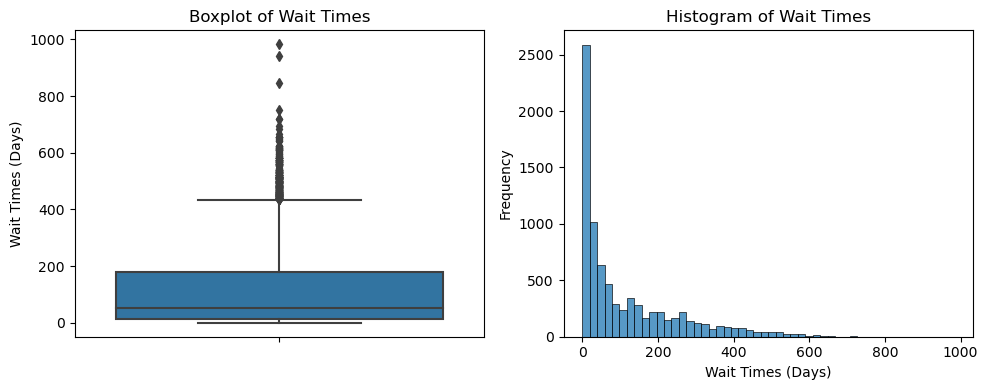

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

# Plot the boxplot on the first subplot
sns.boxplot(y='Wait_Time', data=df, ax=ax1)
ax1.set_title('Boxplot of Wait Times')
ax1.set_ylabel('Wait Times (Days)')

# Plot the histogram on the second subplot
sns.histplot(x='Wait_Time', data=df, bins=50, ax=ax2)
ax2.set_title('Histogram of Wait Times')
ax2.set_xlabel('Wait Times (Days)')
ax2.set_ylabel('Frequency')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Display the combined plots
plt.show()

Pairwise correlation analysis

In [11]:
df.corr()

,Patient_Age,Index_of_Multiple_Deprivation,Wait_Time
Patient_Age,1.000000,0.176638,-0.004635
Index_of_Multiple_Deprivation,0.176638,1.000000,-0.021454
Wait_Time,-0.004635,-0.021454,1.000000


## Single Independent Variable Analysis

### Patient Age

Visualizing the relationship between 'Patient_Age' and 'Wait_Time'

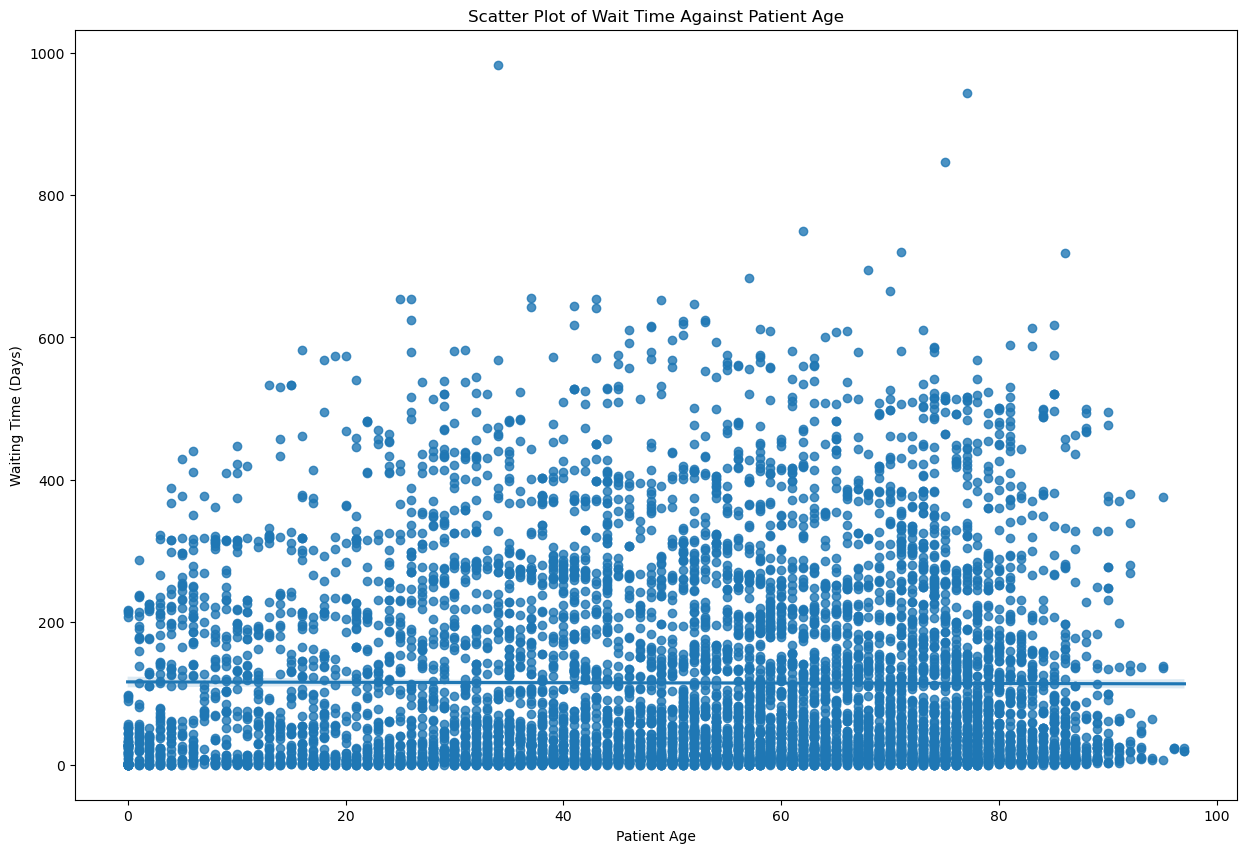

In [12]:
plt.figure(figsize=(15, 10))
sns.regplot(x='Patient_Age', y='Wait_Time', data=df, order=1)
plt.title('Scatter Plot of Wait Time Against Patient Age')
plt.xlabel('Patient Age')
plt.ylabel ('Waiting Time (Days)')
plt.show()

Categorising 'Patient_Age' for grouped analysis

In [13]:
bins = [-1, 18, 39, 64, 100]
age_groups = ['0-18', '19-39', '40-64', '65+']
df['Age_Group'] = pd.cut(df['Patient_Age'], bins=bins, labels=age_groups)
df.head()

,Patient_Age,Index_of_Multiple_Deprivation,Ethnicity,Seen_Date,Wait_Start_Date,Wait_Time,Age_Group
0,47,7,White British,2023-01-01,2022-12-28,4,40-64
1,55,9,White British,2023-01-02,2022-12-03,30,40-64
2,80,4,White - any other white background,2023-01-14,2022-10-22,84,65+
3,42,6,White British,2023-01-29,2023-01-20,9,40-64
4,23,7,White British,2023-01-22,2022-12-22,31,19-39


In [14]:
age_grouped = df.groupby('Age_Group')['Wait_Time']
age_grouped.describe()

,count,mean,std,min,25%,50%,75%,max
Age_Group,,,,,,,,
0-18,856.0,101.823598,114.497051,0.0,9.0,52.0,180.0,582.0
19-39,1519.0,119.011192,144.369970,0.0,9.0,48.0,200.5,983.0
40-64,2856.0,118.846289,139.938295,0.0,13.0,55.0,190.0,750.0
65+,2879.0,112.608545,135.968793,0.0,15.0,51.0,160.0,943.0


Testing for normality across age groups to inform which statistical test to use
- Null Hypothesis ($H_0$): Samples come from a normal distribution
- Alternative Hypothesis ($H_A$): Samples do not come from a normal distribution

In [15]:
age_grouped_names, age_grouped_values = zip(*[(name, group.values) for name, group in age_grouped])

In [16]:
print("Shapiro-Wilk Test p-values")

for group_name, group_values in zip(age_grouped_names, age_grouped_values):
    stat, p = stats.shapiro(group_values)
    print(group_name,":", p)

Shapiro-Wilk Test p-values
0-18 : 4.0047083095452266e-29
19-39 : 9.909226038534371e-40
40-64 : 0.0
65+ : 0.0


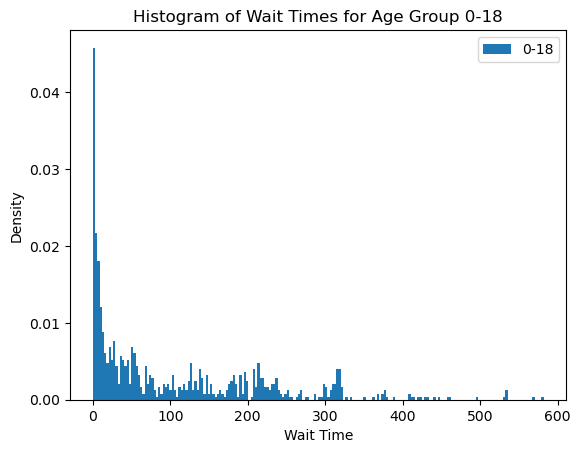

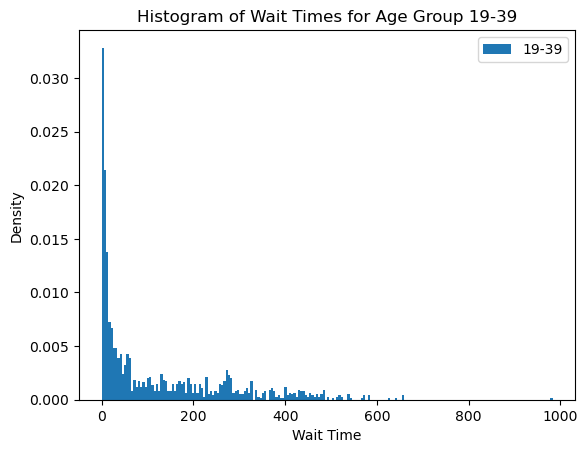

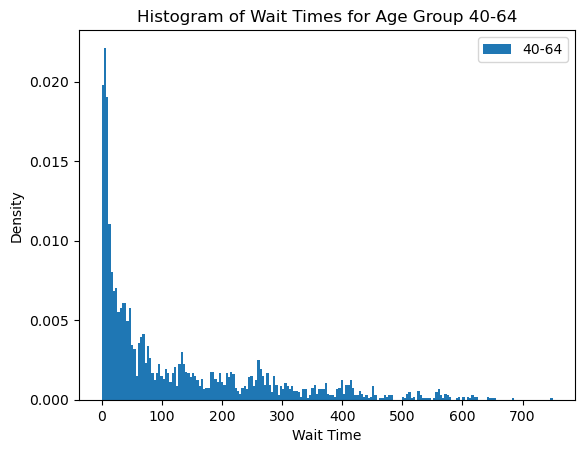

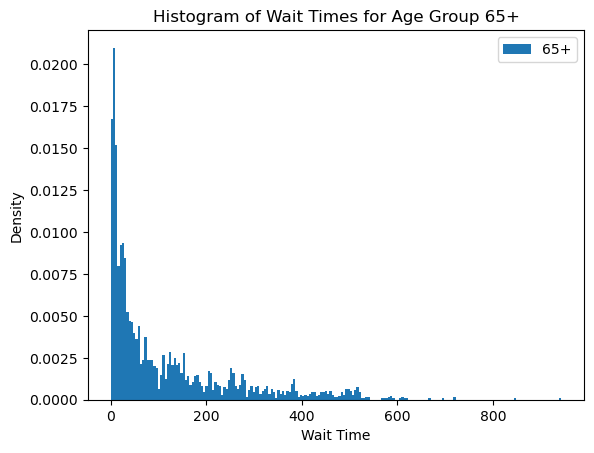

In [17]:
for name, group in age_grouped:
    plt.hist(group, bins=200, density=True, label=name)
    plt.title(f'Histogram of Wait Times for Age Group {name}')
    plt.xlabel('Wait Time')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

Since normality is violated (p < 0.05), we proceed with non-parametric tests for comparisons.

Test for equal variance
- Null Hypothesis ($H_0$): Variances are equal across all age groups
- Alternative Hypothesis ($H_A$): Variances between at least one pair of age groups are not equal

In [18]:
stat, p = stats.levene(*age_grouped_values)
print("Levene's Test - p-value:", p)

Levene's Test - p-value: 0.00017759187521573281


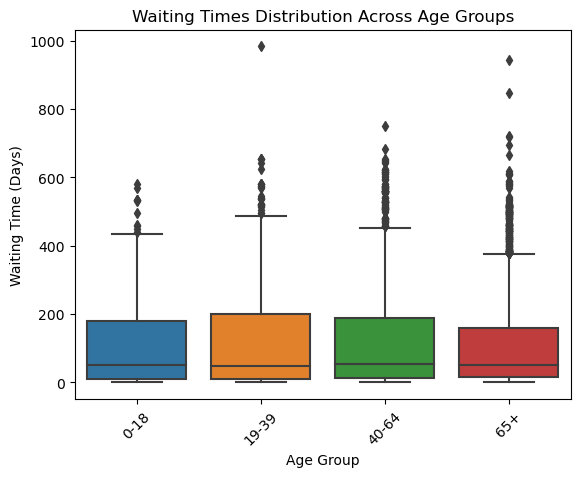

In [19]:
sns.boxplot(x ='Age_Group', y='Wait_Time', data = df)
plt.title('Waiting Times Distribution Across Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Waiting Time (Days)')
plt.xticks(rotation=45)
plt.show()

Since p<0.05, we reject the null hypothesis and conclude that the variances between at least a pair of groups are not equal.

With both normality and equal variances assumptions violated, we can use Kruskal-Wallis test which compares the median ranks of the groups rather than means and does not rely on assumptions about the distribution of the data or the equality of variances.

The null hypothesis of the Kruskal-Wallis test is that the mean ranks of the groups are the same. it is more appropriate to use ranks rather than actual values to avoid the testing being affected by the presence of outliers or by the nonnormal distribution of data.

In [20]:
stats.kruskal(*age_grouped_values)

KruskalResult(statistic=14.165171370827961, pvalue=0.0026887331311718247)

Dunn's posthoc test with Bonferroni correction - Adjusting for multiple comparisons is crucial to control the family-wise error rate and avoid false positive results

In [21]:
import scikit_posthocs as sp

# Perform Dunn's test with Bonferroni correction
age_dunn_results = sp.posthoc_dunn(list(age_grouped_values), p_adjust='bonferroni')

# Print the Dunn's test results
age_dunn_results.index = age_grouped_names
age_dunn_results.columns = age_grouped_names
age_dunn_results

,0-18,19-39,40-64,65+
0-18,1.000000,1.000000,0.013157,0.067033
19-39,1.000000,1.000000,0.039733,0.230474
40-64,0.013157,0.039733,1.000000,1.000000
65+,0.067033,0.230474,1.000000,1.000000


In [22]:
age_dunn_results[age_dunn_results < 0.05]

,0-18,19-39,40-64,65+
0-18,NaN,NaN,0.013157,NaN
19-39,NaN,NaN,0.039733,NaN
40-64,0.013157,0.039733,NaN,NaN
65+,NaN,NaN,NaN,NaN


### Index of Multiple Deprivation

In [23]:
IMD_grouped = df.groupby('Index_of_Multiple_Deprivation')['Wait_Time']
IMD_grouped.describe()

,count,mean,std,min,25%,50%,75%,max
Index_of_Multiple_Deprivation,,,,,,,,
1,943.0,119.273595,143.604765,0.0,8.00,49.0,209.00,652.0
2,686.0,89.427114,117.150099,0.0,9.00,37.0,128.75,665.0
3,1002.0,133.285429,138.719455,0.0,15.00,80.5,219.25,596.0
4,1540.0,120.220779,141.209564,0.0,13.00,58.0,186.25,654.0
5,910.0,114.281319,143.130380,0.0,13.25,52.0,162.00,847.0
6,913.0,115.146769,136.659803,0.0,15.00,50.0,169.00,623.0
7,694.0,101.842939,125.953185,0.0,12.00,44.0,153.00,983.0
8,708.0,129.836158,148.850128,0.0,16.00,61.5,195.25,943.0
9,546.0,96.335165,117.305354,0.0,12.00,42.0,152.50,654.0


Test for normality
- Null Hypothesis ($H_0$): Samples come from a normal distribution
- Alternative Hypothesis ($H_A$): Samples do not come from a normal distribution

In [24]:
IMD_grouped_names, IMD_grouped_values = zip(*[(name, group.values) for name, group in IMD_grouped])

In [25]:
print("Shapiro-Wilk Test p-values")

for group_name, group_values in zip(IMD_grouped_names, IMD_grouped_values):
    stat, p = stats.shapiro(group_values)
    print(group_name,":", p)

Shapiro-Wilk Test p-values
1 : 1.5466581614623633e-32
2 : 6.826552727428623e-31
3 : 2.4872247729387747e-29
4 : 8.419407550218155e-40
5 : 5.320249320090768e-34
6 : 2.5410755421273455e-32
7 : 4.7129499377574656e-30
8 : 6.480190928354315e-28
9 : 2.2130605227457113e-26
10 : 6.318088104392383e-16


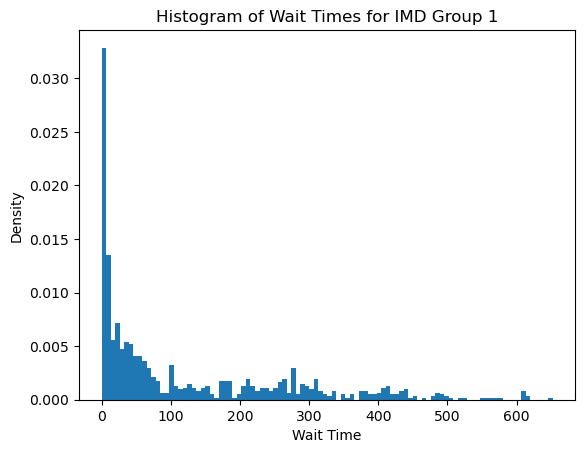

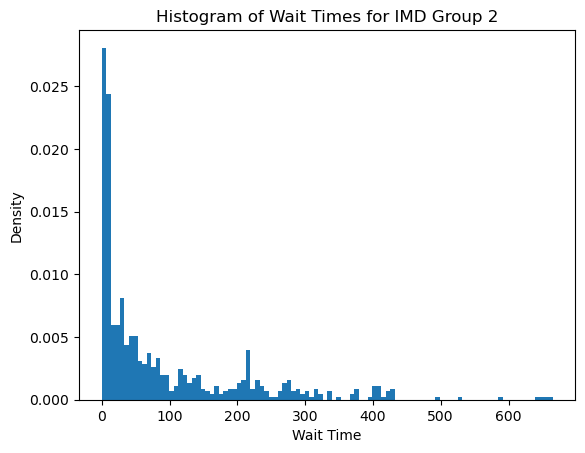

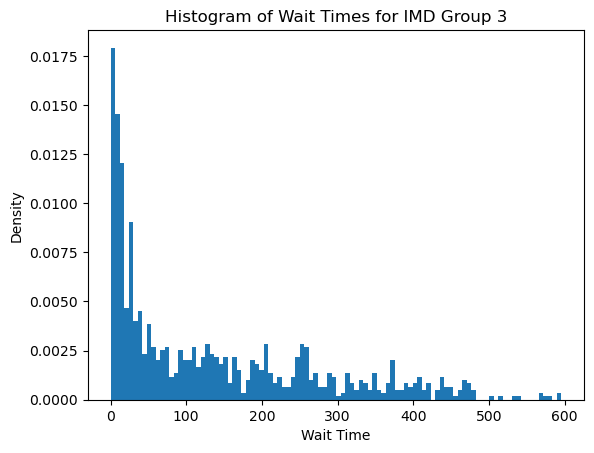

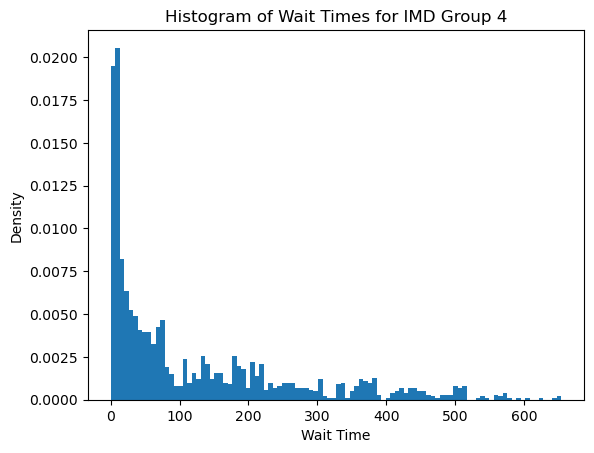

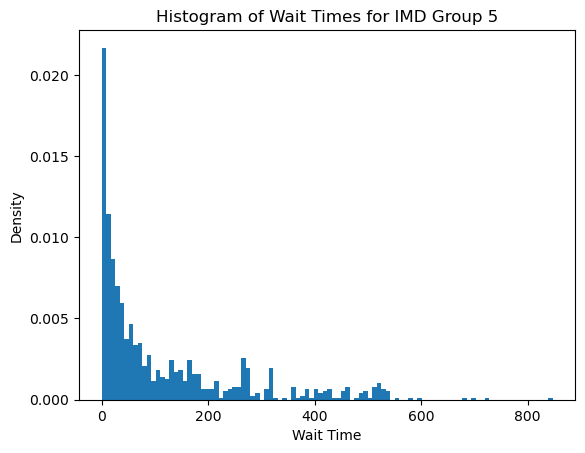

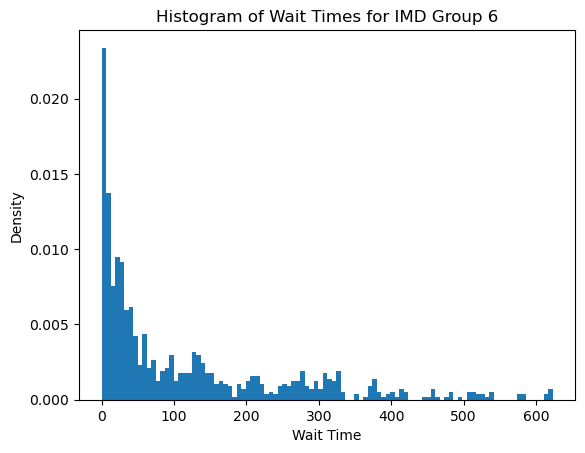

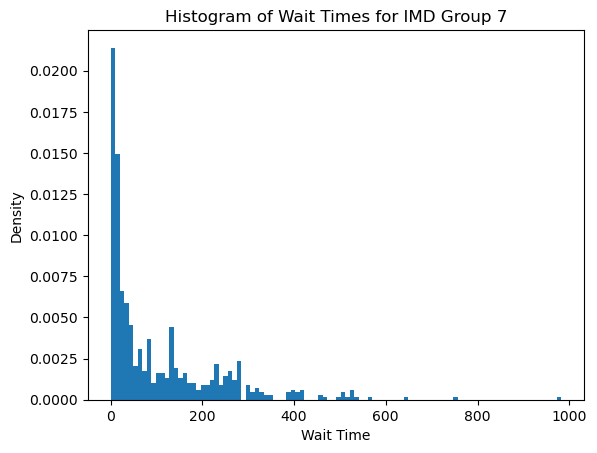

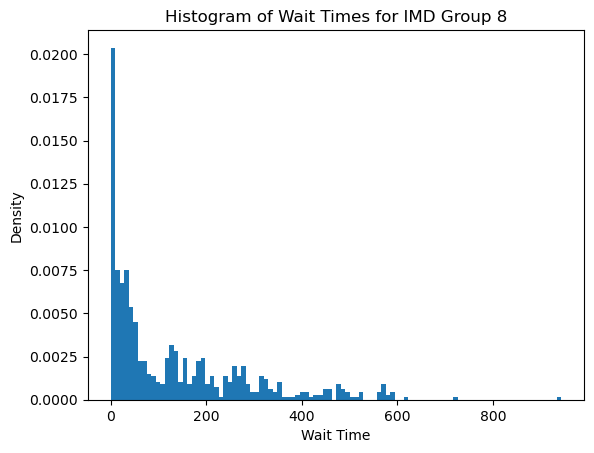

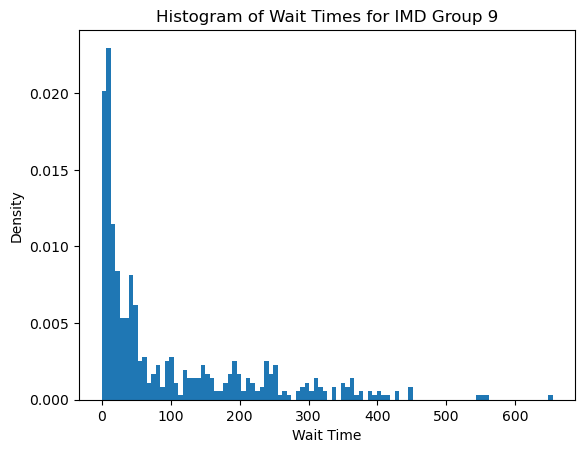

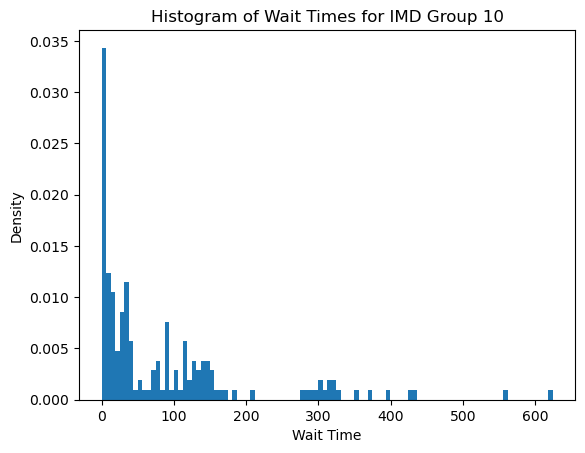

In [26]:
for name, group in IMD_grouped:
    plt.hist(group, bins=100, density=True)
    plt.title(f'Histogram of Wait Times for IMD Group {name}')
    plt.xlabel('Wait Time')
    plt.ylabel('Density')
    plt.show()

Test for equal variance
- Null Hypothesis ($H_0$): Variances are equal across all age groups
- Alternative Hypothesis ($H_A$): Variances between at least one pair of age groups are not equal

In [27]:
stat, p = stats.levene(*IMD_grouped_values)
print("Levene's Test - p-value:", p)

Levene's Test - p-value: 2.0296911244376428e-11


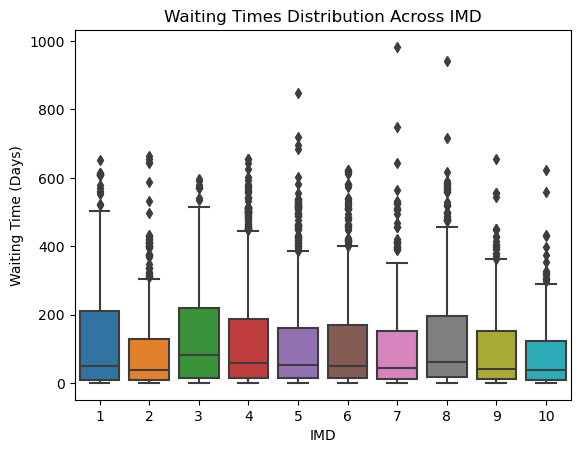

In [28]:
sns.boxplot(x='Index_of_Multiple_Deprivation', y='Wait_Time',data=df)
plt.title('Waiting Times Distribution Across IMD')
plt.xlabel('IMD')
plt.ylabel('Waiting Time (Days)')
plt.show()

Since p<0.05, we reject the null hypothesis and conclude that the variances between at least a pair of groups are not equal.

With both normality and equal variances assumptions violated, we can use Kruskal-Wallis test to compare the medians.

In [29]:
stats.kruskal(*IMD_grouped_values)

KruskalResult(statistic=71.06664499668874, pvalue=9.403784034767982e-12)

In [30]:
# Perform Dunn's test with Bonferroni correction
IMD_dunn_results = sp.posthoc_dunn(list(IMD_grouped_values), p_adjust='bonferroni')

# Print the Dunn's test results
IMD_dunn_results.index = IMD_grouped_names
IMD_dunn_results.columns = IMD_grouped_names
IMD_dunn_results

,1,2,3,4,5,6,7,8,9,10
1,1.000000,8.128256e-02,2.532116e-03,1.000000,1.000000,1.000000,1.000000,0.278193,1.000000,1.000000
2,0.081283,1.000000e+00,3.380874e-10,0.000032,0.013474,0.002762,0.887819,0.000002,1.000000,1.000000
3,0.002532,3.380874e-10,1.000000e+00,0.268552,0.028411,0.125109,0.000673,1.000000,0.000219,0.003763
4,1.000000,3.152255e-05,2.685520e-01,1.000000,1.000000,1.000000,1.000000,1.000000,0.371957,0.348696
5,1.000000,1.347445e-02,2.841133e-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
6,1.000000,2.762457e-03,1.251093e-01,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
7,1.000000,8.878194e-01,6.728812e-04,1.000000,1.000000,1.000000,1.000000,0.078564,1.000000,1.000000
8,0.278193,2.092593e-06,1.000000e+00,1.000000,1.000000,1.000000,0.078564,1.000000,0.025143,0.046954
9,1.000000,1.000000e+00,2.185077e-04,0.371957,1.000000,1.000000,1.000000,0.025143,1.000000,1.000000
10,1.000000,1.000000e+00,3.763015e-03,0.348696,1.000000,1.000000,1.000000,0.046954,1.000000,1.000000


In [31]:
IMD_dunn_results[IMD_dunn_results < 0.05]

,1,2,3,4,5,6,7,8,9,10
1,NaN,NaN,2.532116e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,3.380874e-10,0.000032,0.013474,0.002762,NaN,0.000002,NaN,NaN
3,0.002532,3.380874e-10,NaN,NaN,0.028411,NaN,0.000673,NaN,0.000219,0.003763
4,NaN,3.152255e-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,1.347445e-02,2.841133e-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,2.762457e-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,6.728812e-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,2.092593e-06,NaN,NaN,NaN,NaN,NaN,NaN,0.025143,0.046954
9,NaN,NaN,2.185077e-04,NaN,NaN,NaN,NaN,0.025143,NaN,NaN
10,NaN,NaN,3.763015e-03,NaN,NaN,NaN,NaN,0.046954,NaN,NaN


### Ethnicity Analysis

In [32]:
df.groupby('Ethnicity')['Wait_Time'].describe()

,count,mean,std,min,25%,50%,75%,max
Ethnicity,,,,,,,,
Asian/Asian British Indian,14.0,46.000000,131.731662,0.0,2.00,4.5,8.75,496.0
Asian/Asian British Pakistani,4.0,314.500000,7.141428,307.0,310.75,313.5,317.25,324.0
Asian/Asian British any other Asian background,84.0,16.023810,57.234032,0.0,2.00,5.0,10.25,496.0
Black - any other black background,29.0,67.241379,79.880113,2.0,13.00,57.0,72.00,303.0
Black or Black British African,13.0,154.846154,105.826782,1.0,28.00,173.0,235.00,280.0
Black or Black British Caribbean,2.0,152.500000,71.417785,102.0,127.25,152.5,177.75,203.0
Chinese,4.0,312.000000,246.017615,45.0,132.75,331.0,510.25,541.0
Mixed - any other mixed background,35.0,61.628571,69.872609,1.0,20.00,55.0,57.50,317.0
Mixed White and Asian,8.0,58.250000,83.887254,10.0,11.00,12.0,64.25,197.0


Combine similar ethnic backgrounds into a group for larger sample size
- Asian: Asian/Asian British Indian, Asian/Asian British Pakistani, Asian/Asian British any other Asian background, Chinese
- Black: Black - any other black background, Black or Black British African, Black or Black British Caribbean
- Mixed: Mixed - any other mixed background, Mixed White and Asian, Mixed White and Black African, Mixed White and Black Caribbean
- Other ethnic group
- Unknown: Unknown, Unwilling to answer
- White: White - any other white background, White British, White Irish

In [33]:
# Define combined ethnicity categories
combined_ethnicities = {
    "White": ["White British", "White - any other white background", "White Irish"],
    "Asian": ["Asian/Asian British Indian", "Asian/Asian British Pakistani", \
              "Asian/Asian British any other Asian background", "Chinese"],
    "Black": ["Black - any other black background", "Black or Black British African", \
              "Black or Black British Caribbean"],
    "Mixed": ["Mixed - any other mixed background", "Mixed White and Asian", \
              "Mixed White and Black African", "Mixed White and Black Caribbean"],
    "Other ethnic group": ["Other ethnic group - other"],
    "Unknown": ["Unknown", "Unwilling to answer"]
}

# Replace ethnicity values with combined categories
for combined_category, ethnicities in combined_ethnicities.items():
    df['Ethnicity'] = df['Ethnicity'].replace(ethnicities, combined_category)
    
df.head()

,Patient_Age,Index_of_Multiple_Deprivation,Ethnicity,Seen_Date,Wait_Start_Date,Wait_Time,Age_Group
0,47,7,White,2023-01-01,2022-12-28,4,40-64
1,55,9,White,2023-01-02,2022-12-03,30,40-64
2,80,4,White,2023-01-14,2022-10-22,84,65+
3,42,6,White,2023-01-29,2023-01-20,9,40-64
4,23,7,White,2023-01-22,2022-12-22,31,19-39


In [34]:
eth_grouped = df.groupby('Ethnicity')['Wait_Time']
eth_grouped.describe()

,count,mean,std,min,25%,50%,75%,max
Ethnicity,,,,,,,,
Asian,106.0,42.415094,112.322484,0.0,2.00,6.0,11.75,541.0
Black,44.0,97.000000,95.661467,1.0,14.75,66.5,174.25,303.0
Mixed,88.0,65.534091,81.523419,1.0,10.00,29.5,58.75,317.0
Other ethnic group,237.0,151.945148,136.900810,0.0,23.00,130.0,262.00,512.0
Unknown,688.0,69.175872,87.152243,0.0,7.00,30.0,117.25,513.0
White,6947.0,119.969627,140.712056,0.0,13.00,56.0,188.00,983.0


Test for normality
- Null Hypothesis ($H_0$): Samples come from a normal distribution
- Alternative Hypothesis ($H_A$): Samples do not come from a normal distribution

In [35]:
eth_grouped_names, eth_grouped_values = zip(*[(name, group.values) for name, group in eth_grouped])

In [36]:
print("Shapiro-Wilk Test p-values")

for group_name, group_values in zip(eth_grouped_names, eth_grouped_values):
    stat, p = stats.shapiro(group_values)
    print(group_name,":", p)

Shapiro-Wilk Test p-values
Asian : 7.54270586917131e-19
Black : 2.8952827051398344e-05
Mixed : 2.2156762535807673e-11
Other ethnic group : 7.23777266418979e-13
Unknown : 5.243654980261059e-30
White : 0.0


/Users/techonn/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


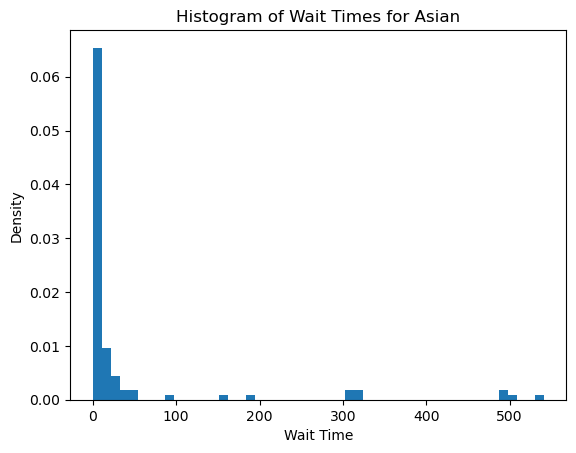

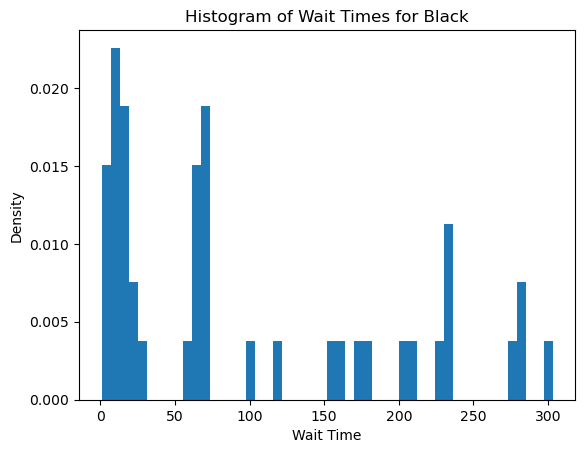

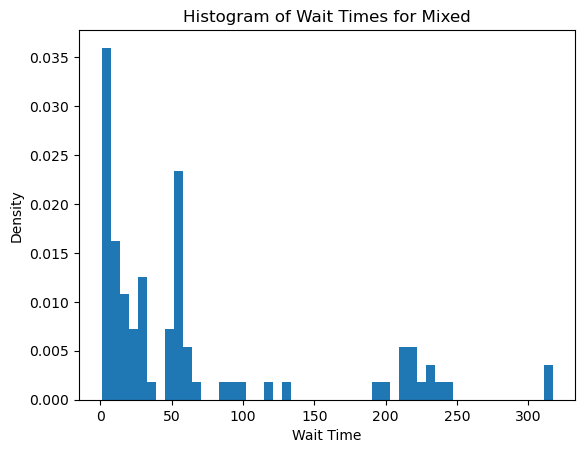

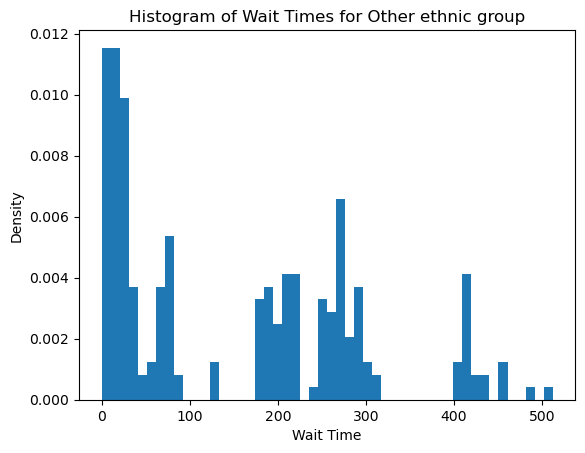

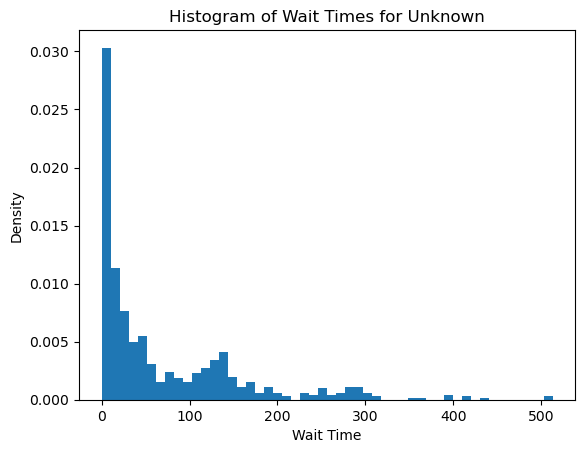

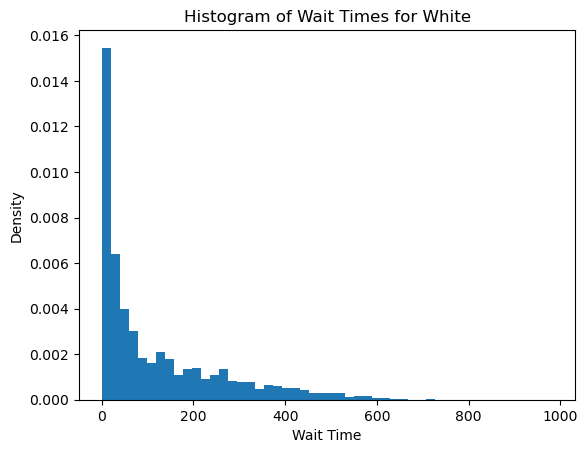

In [37]:
for name, group in eth_grouped:
    plt.hist(group, bins=50, density=True)
    plt.title(f'Histogram of Wait Times for {name}')
    plt.xlabel('Wait Time')
    plt.ylabel('Density')
    plt.show()

Test for equal variance
- Null Hypothesis ($H_0$): Variances are equal across all age groups
- Alternative Hypothesis ($H_A$): Variances between at least one pair of age groups are not equal

In [38]:
stats, p = stats.levene(*eth_grouped_values)
print("Levene's Test - p-value:", p)

Levene's Test - p-value: 1.5698535189120874e-28


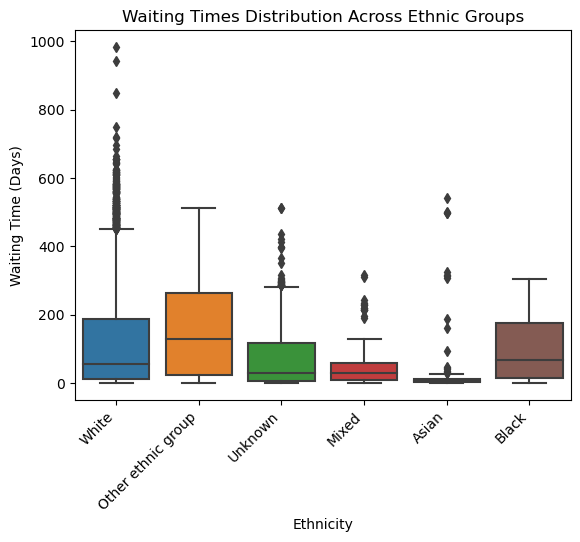

In [39]:
sns.boxplot(x='Ethnicity', y='Wait_Time',data=df)
plt.title('Waiting Times Distribution Across Ethnic Groups')
plt.xlabel('Ethnicity')
plt.ylabel('Waiting Time (Days)')
plt.xticks(rotation=45, ha='right')
plt.show()

Since p<0.05, we reject the null hypothesis and conclude that the variances between at least a pair of groups are not equal.

With both normality and equal variances assumptions violated, we can use Kruskal-Wallis test to compare the medians.

In [40]:
stats.kruskal(*eth_grouped_values)

AttributeError: 'numpy.float64' object has no attribute 'kruskal'

In [ ]:
# Perform Dunn's test with Bonferroni correction
eth_dunn_results = sp.posthoc_dunn(list(eth_grouped_values), p_adjust='bonferroni')

# Print the Dunn's test results
eth_dunn_results.index = eth_grouped_names
eth_dunn_results.columns = eth_grouped_names
eth_dunn_results

In [ ]:
eth_dunn_results[eth_dunn_results < 0.05]

# Combined Analysis with Quintile Regression

Want to explore if there's any seasonal fluctuation in referral dates. If so, want to control for this in regression model.

In [41]:
df['Referral_Month'] = df['Wait_Start_Date'].dt.month

In [42]:
df['Referral_Month'] = df['Referral_Month'].astype('int')

Observing seasonal fluctuation in waiting time

In [43]:
ref_grouped = df.groupby('Referral_Month')['Wait_Time']
ref_grouped.describe()

,count,mean,std,min,25%,50%,75%,max
Referral_Month,,,,,,,,
1,1960.0,29.049490,89.243415,0.0,2.00,6.0,10.00,720.0
2,154.0,330.818182,31.551484,309.0,319.25,327.0,337.00,695.0
3,191.0,317.240838,72.203620,280.0,294.00,303.0,311.00,684.0
4,320.0,275.428125,46.352484,247.0,262.00,270.0,277.25,647.0
5,261.0,271.153257,106.363091,218.0,233.00,244.0,252.00,983.0
6,334.0,251.050898,119.562618,190.0,204.00,212.0,219.00,943.0
7,341.0,213.659824,104.305893,154.0,175.00,182.0,191.00,565.0
8,492.0,198.804878,127.813568,123.0,139.00,149.0,161.00,535.0
9,506.0,159.579051,116.209876,95.0,112.00,122.0,132.00,847.0


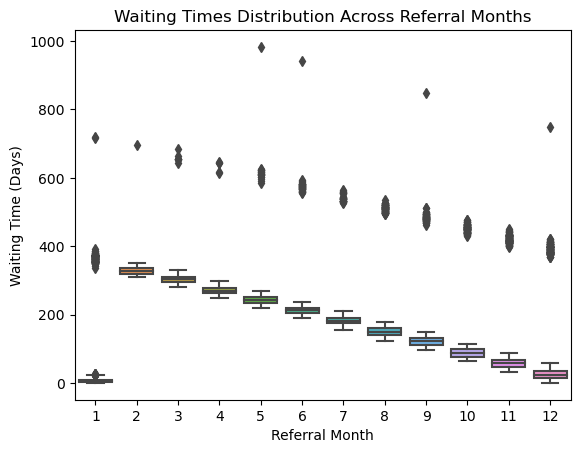

In [44]:
sns.boxplot(x='Referral_Month', y='Wait_Time',data=df)
plt.title('Waiting Times Distribution Across Referral Months')
plt.xlabel('Referral Month')
plt.ylabel('Waiting Time (Days)')
plt.show()

In [45]:
df.drop(columns=['Seen_Date','Wait_Start_Date'], inplace=True)

In [46]:
df['Referral_Month'] = df['Referral_Month'].astype('category')
df['Index_of_Multiple_Deprivation'] = df['Index_of_Multiple_Deprivation'].astype('category')

In [47]:
import statsmodels.api as sm
import statsmodels.regression.quantile_regression as smqr

# First, one-hot encode 'Age_Group', 'Referral_Month', and 'Index_of_Multiple_Deprivation'
# For 'Ethnicity', encode it separately to manually control the reference group
categorical_vars = ['Age_Group', 'Referral_Month', 'Index_of_Multiple_Deprivation']
df_encoded = pd.get_dummies(df[['Age_Group', 'Referral_Month', 'Index_of_Multiple_Deprivation']],drop_first=True)

# One-hot encode 'Ethnicity', keeping 'White' as the baseline, so not included in the model
ethnicity_dummies = pd.get_dummies(df['Ethnicity'])

# Drop the 'White' column to use it as the reference group
ethnicity_dummies = ethnicity_dummies.drop('White', axis=1)

# Join the new ethnicity dummies to the rest of the encoded DataFrame
df_encoded = pd.concat([df_encoded, ethnicity_dummies], axis=1)

In [48]:
# Prepare independent (X) and dependent (y) variables
X = df_encoded
y = df['Wait_Time']

# Add a constant to the model for the intercept
X = sm.add_constant(X)

# Perform quantile regression for specified quantiles
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]  # Define quantiles
results = {}  # Dictionary to store results

for q in quantiles:
    model = smqr.QuantReg(y, X)
    res = model.fit(q=q)
    results[q] = res

/Users/techonn/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/quantile_regression.py:191: IterationLimitWarning: Maximum number of iterations (1000) reached.
  warnings.warn("Maximum number of iterations (" + str(max_iter) +


In [58]:
print(results[0.9].summary())

                         QuantReg Regression Results                          
Dep. Variable:              Wait_Time   Pseudo R-squared:               0.2212
Model:                       QuantReg   Bandwidth:                       27.07
Method:                 Least Squares   Sparsity:                        119.4
Date:                Mon, 19 Feb 2024   No. Observations:                 8110
Time:                        13:43:50   Df Residuals:                     8081
                                        Df Model:                           28
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               16.0000      1.728      9.261      0.000      12.613      19.387
Age_Group_19-39                     11.0000      1.574      6.990      0.000       7.915      14.085
Age_Group_40-64                     10.5000

In [50]:
# Initialize an empty DataFrame to store the results
coefficients_df = pd.DataFrame()

for q, result in results.items():
    # Extract coefficients, round them, and convert to string for formatting
    coef = result.params.round(3).astype(str)
    
    # Extract p-values and convert to significance levels
    pvalues = result.pvalues.apply(lambda x: '***' if x <= 0.01 else '**' if x <= 0.05 else '*' if x <= 0.1 else '')
    
    # Combine coefficients and significance levels into a single string
    combined = coef + pvalues
    
    # Create a DataFrame for the current quantile
    quantile_df = pd.DataFrame({f'Q({q:.2f})': combined})
    
    # If it's the first quantile, initialize the coefficients_df DataFrame
    if coefficients_df.empty:
        coefficients_df = quantile_df
    else:
        # Otherwise, join the new DataFrame with the existing one
        coefficients_df = coefficients_df.join(quantile_df)

In [51]:
coefficients_df

,Q(0.10),Q(0.25),Q(0.50),Q(0.75),Q(0.90)
const,0.0,0.667,3.234***,8.0***,16.0***
Age_Group_19-39,0.5,1.124**,2.267***,3.0***,11.0***
Age_Group_40-64,0.0,1.333***,2.767***,3.0***,10.5***
Age_Group_65+,1.0***,2.0***,3.0***,3.0***,8.0***
Referral_Month_2,315.0***,317.333***,320.988***,325.0***,320.5***
Referral_Month_3,287.0***,291.791***,297.766***,301.0***,300.5***
Referral_Month_4,255.0***,259.333***,264.383***,266.0***,262.0***
Referral_Month_5,226.0***,231.333***,237.733***,242.0***,243.0***
Referral_Month_6,197.0***,201.791***,206.0***,208.0***,534.5***
Referral_Month_7,166.0***,172.469***,176.0***,180.0***,190.0***


In [52]:
quintiles = df['Wait_Time'].quantile([0.1, 0.25, 0.5, 0.75, 0.9])

# Display the quintiles
print(quintiles)

0.10      4.0
0.25     12.0
0.50     52.0
0.75    181.0
0.90    318.0
Name: Wait_Time, dtype: float64


In [53]:
# Identify rows that should be moved to the bottom (starting with 'Referral_Month')
rows_to_move = coefficients_df.index.str.startswith('Referral_Month')

# Split the DataFrame into two parts
df_top = coefficients_df[~rows_to_move]
df_bottom = coefficients_df[rows_to_move]

# Recombine the DataFrames to move specified rows to the bottom
df_reordered = pd.concat([df_top, df_bottom])

# Display the reordered DataFrame
df_reordered

,Q(0.10),Q(0.25),Q(0.50),Q(0.75),Q(0.90)
const,0.0,0.667,3.234***,8.0***,16.0***
Age_Group_19-39,0.5,1.124**,2.267***,3.0***,11.0***
Age_Group_40-64,0.0,1.333***,2.767***,3.0***,10.5***
Age_Group_65+,1.0***,2.0***,3.0***,3.0***,8.0***
Index_of_Multiple_Deprivation_2,0.0,-0.802,-0.5,-1.0,-8.5***
Index_of_Multiple_Deprivation_3,-0.5,-0.457,1.0*,2.0***,4.0**
Index_of_Multiple_Deprivation_4,0.0,-0.667,0.0,1.0,2.0
Index_of_Multiple_Deprivation_5,0.0,0.864*,0.767,1.0,2.0
Index_of_Multiple_Deprivation_6,0.0,0.667,1.0,1.0,0.0
Index_of_Multiple_Deprivation_7,0.0,-0.333,-0.233,-1.0,-8.5***
